In [189]:
#### Imports ############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import re

from sklearn import set_config

#### Settings ###########
sns.set()
pd.options.display.max_columns = 500
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = [10, 5]
set_config(display="diagram")
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

Notebook desenvolvido por *Maykon Schots* em 2020. Por favor, ao compartilhar verifique a **3-Clause BSD License.** 

# 1. Raw Data

In [205]:
enem = pd.read_csv("train.csv", index_col=0)

<IPython.core.display.Javascript object>

In [206]:
enem.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,NO_ENTIDADE_CERTIFICACAO,CO_UF_ENTIDADE_CERTIFICACAO,SG_UF_ENTIDADE_CERTIFICACAO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TX_RESPOSTAS_CN,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,4314902,Porto Alegre,43,RS,1,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,ABACCABDBEDEDEEDDDBBBDAABABECDCCCAAABCBEEABCA,BBEBCAEBCEDBDDEBCACDBCBDABDDCDBEDCEAEABCAADAC,99999DCABCABCBBCADBCBBABAEADBEEBEDAAABAEAECCBB...,AECCCBABDCADDBCBCCADADBBAADEBCEEBABCDDEAABCAA,1,BCADBCEDCCBADBDCADBEBDBEADCCAEACDBEDBCACAEBEE,BCBCCADCCBEDDBEEADBDCECCBBECAEEDDADCDDACAADBA,CEDEACCBEBDBABECABDADEADCEDCBEBBCEBAAEBAAECBBC...,DADCCECBDECADCBACDBCEEABDDAABDBCEADDBECEBAEBC,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,B,B,3,C,A,B,B,B,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D
2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2304707,Granja,23,CE,1,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,EDAAABDABADBCCAEDCDDECABADBEECBBAEEDCABCAABBC,ADCAABAADCEDAACDACEEDACBDCBACEDEDBACAADADABDC,99999ACBACDBDBCEADDAEEADCCEACEEDBECAAAACBECDAC...,AEDACBDECEDAEEAEDDEBDECDCECACADCACACAABDACEAB,1,EBEECADBCABECDDBEADCCABDEABEBCADBADDCCCEDBBCA,DCECBAAADCBBECAEDCEDDACCBDDACEDDBADBCADBCBCEE,CEDEACCBEBDBABECABDADEADCEDCBEBBCEBAAEBAAECBBC...,DADCCECBDECADCBACDBCEEABDDAABDBCEADDBECEBAEBC,1.0

<IPython.core.display.Javascript object>

In [207]:
f"{enem.shape[0]} linhas, {enem.shape[1]} colunas"

'13730 linhas, 166 colunas'

<IPython.core.display.Javascript object>

In [208]:
# Neither Students Identifiers nor the year have any prediction power.
enem.drop(["NU_INSCRICAO", "NU_ANO"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [6]:
# Missingness % Check
na_cols = [col for col in enem if (enem[col].isna().sum() > 0)]
enem[na_cols].isna().mean().sort_values(ascending=False).mul(100)

NO_ENTIDADE_CERTIFICACAO       88.069920
CO_UF_ENTIDADE_CERTIFICACAO    88.069920
SG_UF_ENTIDADE_CERTIFICACAO    88.069920
Q041                           78.601602
SG_UF_ESC                      68.812819
TP_LOCALIZACAO_ESC             68.812819
TP_SIT_FUNC_ESC                68.812819
CO_UF_ESC                      68.812819
NO_MUNICIPIO_ESC               68.812819
CO_MUNICIPIO_ESC               68.812819
CO_ESCOLA                      68.812819
TP_ENSINO                      68.812819
TP_DEPENDENCIA_ADM_ESC         68.812819
Q032                           53.721777
Q031                           53.721777
Q028                           53.721777
Q033                           53.721777
Q030                           53.714494
Q029                           53.714494
Q027                           53.699927
NU_NOTA_COMP1                  26.198106
NU_NOTA_LC                     26.198106
NU_NOTA_REDACAO                26.198106
NU_NOTA_MT                     26.198106
TP_STATUS_REDACA

<IPython.core.display.Javascript object>

In [7]:
# Target Has Missing Values :( Let's dive to see it
enem["NU_NOTA_MT"].describe()

count    10133.000000
mean       482.497928
std         99.826323
min          0.000000
25%        408.900000
50%        461.200000
75%        537.600000
max        952.000000
Name: NU_NOTA_MT, dtype: float64

<IPython.core.display.Javascript object>

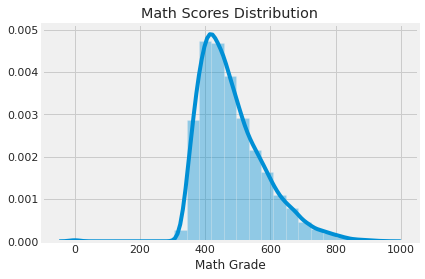

<IPython.core.display.Javascript object>

In [8]:
ax = sns.distplot(enem["NU_NOTA_MT"], bins=25)
ax.set_title("Math Scores Distribution")
_ = ax.set_xlabel("Math Grade")

# 2. Baseline Model

This baseline model has one simple claim : All the information needed to predict one's mathematics grade is contained in the grades of the other disciplines. A super simple model indeed.

In [209]:
baseline_features = [feature for feature in enem if "NU_NOTA" in feature]
enem_baseline_data = enem[baseline_features]
f"{enem_baseline_data.shape[1]} features no modelo Baseline"

'10 features no modelo Baseline'

<IPython.core.display.Javascript object>

In [57]:
enem_baseline_data.head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
1,436.3,495.4,581.2,399.4,120.0,120.0,120.0,80.0,80.0,520.0
2,474.5,544.1,599.0,459.8,140.0,120.0,120.0,120.0,80.0,580.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [11]:
# Fill with an indicator (0) all grades absent in training data
enem_baseline_data = enem_baseline_data.fillna(0, axis=0)
assert enem_baseline_data.isna().sum().sum() == 0 

<IPython.core.display.Javascript object>

The Random Forest Regressor is chosen as a **strong baseline** due to some very useful factors:
* Captures feature interactions automatically.
* No need to scale features.
* No need to worry about multi-collinearity, homoscedasticity,feature or target distributions,etc. 
* Unbiased estimation of performance on unseen data due to bagging via OOB score parameter for free (no need to split data). 
* We love Random Forests :) 

In [12]:
# Features and Target
X_train, y_train = (
    enem_baseline_data.drop("NU_NOTA_MT", axis=1),
    enem_baseline_data["NU_NOTA_MT"],
)
assert X_train.shape[0] == y_train.shape[0]

<IPython.core.display.Javascript object>

In [13]:
# Preprocessing Instance(Absence of grade Means grade = 0)
imputer = SimpleImputer(strategy="constant", fill_value=0)  # To be used in future data

<IPython.core.display.Javascript object>

In [14]:
# Random Forest Instance using Out of Bag Samples to Evaluate Performance on Unseen Data
rf = RandomForestRegressor(
    n_estimators=200, max_features="sqrt", oob_score=True, random_state=42
)

<IPython.core.display.Javascript object>

In [15]:
# Sklearn Pipeline (just in case if we feel confident to use this model to use on future data)
baseline_pipeline = make_pipeline(imputer, rf)

<IPython.core.display.Javascript object>

In [16]:
# Model Training
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('randomforestregressor',
                 RandomForestRegressor(max_features='sqrt', n_estimators=200,
                                       oob_score=True, random_state=42))])

<IPython.core.display.Javascript object>

In [17]:
f"Baseline R2: {(baseline_pipeline.named_steps.randomforestregressor.oob_score_).round(2)}"

'Baseline R2: 0.92'

<IPython.core.display.Javascript object>

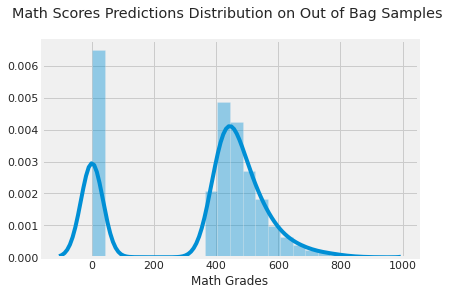

<IPython.core.display.Javascript object>

In [18]:
preds = baseline_pipeline.predict(X_train)  # Predictions on training data
ax = sns.distplot(pd.DataFrame(preds))
ax.set_title("Math Scores Predictions Distribution on Out of Bag Samples \n")
_ = ax.set_xlabel("Math Grades")

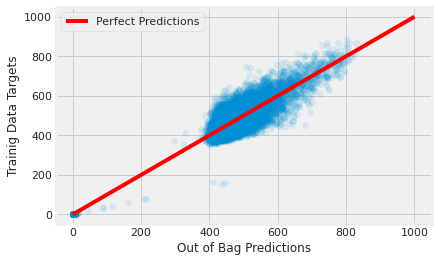

<IPython.core.display.Javascript object>

In [19]:
oob_preds = (
    baseline_pipeline.named_steps.randomforestregressor.oob_prediction_
)  # Out of Bag Samples Predictions
train_preds = baseline_pipeline.predict(X_train)  # Model Predictions
plt.scatter(oob_preds, train_preds, alpha=0.1)
plt.plot([0, 1000], [0, 1000], color="red", label="Perfect Predictions")
_ = plt.legend()
_ = plt.xlabel("Out of Bag Predictions")
_ = plt.ylabel("Trainig Data Targets")

# 3. Baseline Predictions on Test Data

In [20]:
test = pd.read_csv("test.csv", index_col=0)

<IPython.core.display.Javascript object>

In [21]:
# Predictions on Test Data
test_features = [feature for feature in test if "NU_NOTA" in feature]
preds_test = baseline_pipeline.predict(test[test_features])  # Predictions on test data

<IPython.core.display.Javascript object>

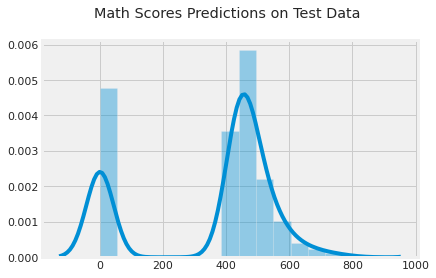

<IPython.core.display.Javascript object>

In [22]:
ax = sns.distplot(pd.DataFrame(preds_test))
_ = ax.set_title("Math Scores Predictions on Test Data \n")

In [23]:
# Predictions CSV file to submission
preds_baseline = pd.DataFrame({"NU_INSCRICAO": [*test.index], "NU_NOTA_MT": preds_test})
preds_baseline.to_csv("answer.csv", index=False, header=True)

<IPython.core.display.Javascript object>

# 4. First Attempt to Beat the Baseline Score 

As the baseline achieved a pretty strong result (93.51%), lets give it a chance to have its hyperparameters tuned. 

In [24]:
# List of Pipeline Tunable Hyperparameters
print([*baseline_pipeline.get_params().keys()])

['memory', 'steps', 'verbose', 'simpleimputer', 'randomforestregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start']


<IPython.core.display.Javascript object>

In [25]:
# Grid Params
pipe_params = {
    "randomforestregressor__n_estimators": [100, 500, 1000],
    "randomforestregressor__max_depth": [1, 5, 10, 25],
    "randomforestregressor__max_features": [*np.arange(0.1, 1.1, 0.1)],
}

<IPython.core.display.Javascript object>

In [26]:
# Tuning
gridsearch = GridSearchCV(
    baseline_pipeline, param_grid=pipe_params, cv=3, n_jobs=-1, verbose=1000
)
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Paralle

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  5.1min
[Paralle

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('randomforestregressor',
                                        RandomForestRegressor(max_features='sqrt',
                                                              n_estimators=200,
                                                              oob_score=True,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [1, 5, 10, 25],
                         'randomforestregressor__max_features': [0.1, 0.2,
                                                                 0.30000000000000004,
                                                                 0.4, 0.5, 0.6,
                                                                 0.7000000000000001,
                                                                 0.8, 0.9,
                                                                 1.0],
                         'randomforestregressor__n_estimators': [100, 500,
                                                                 1000]},
             verbose=1000)

<IPython.core.display.Javascript object>

In [41]:
# Tuned Models Ranking
results = pd.DataFrame(gridsearch.cv_results_)
results.sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__max_features,param_randomforestregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
53,19.018821,0.139066,0.448120,0.173122,5,0.8,1000,"{'randomforestregressor__max_depth': 5, 'rando...",0.923170,0.919342,0.923796,0.922103,0.001969,1
52,9.477850,0.304980,0.219889,0.061061,5,0.8,500,"{'randomforestregressor__max_depth': 5, 'rando...",0.923161,0.919346,0.923787,0.922098,0.001962,2
55,10.824679,0.375832,0.217416,0.068065,5,0.9,500,"{'randomforestregressor__max_depth': 5, 'rando...",0.923202,0.919347,0.923723,0.922090,0.001952,3
54,1.709515,0.161652,0.044973,0.012140,5,0.9,100,"{'randomforestregressor__max_depth': 5, 'rando...",0.923211,0.919335,0.923720,0.922089,0.001958,4
56,19.736262,0.365655,0.461130,0.102472,5,0.9,1000,"{'randomforestregressor__max_depth': 5, 'rando...",0.923222,0.919311,0.923725,0.922086,0.001973,5


<IPython.core.display.Javascript object>

This methodology can be used for other types of models. 
Check --> [Bagging Meta Estimators](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html)

# 5. Feature Engineering

Let's try to put more features into the Random Forest model. 

In [210]:
enem.head()

,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,NO_ENTIDADE_CERTIFICACAO,CO_UF_ENTIDADE_CERTIFICACAO,SG_UF_ENTIDADE_CERTIFICACAO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TX_RESPOSTAS_CN,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
1,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,4314902,Porto Alegre,43,RS,1,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,ABACCABDBEDEDEEDDDBBBDAABABECDCCCAAABCBEEABCA,BBEBCAEBCEDBDDEBCACDBCBDABDDCDBEDCEAEABCAADAC,99999DCABCABCBBCADBCBBABAEADBEEBEDAAABAEAECCBB...,AECCCBABDCADDBCBCCADADBBAADEBCEEBABCDDEAABCAA,1,BCADBCEDCCBADBDCADBEBDBEADCCAEACDBEDBCACAEBEE,BCBCCADCCBEDDBEEADBDCECCBBECAEEDDADCDDACAADBA,CEDEACCBEBDBABECABDADEADCEDCBEBBCEBAAEBAAECBBC...,DADCCECBDECADCBACDBCEEABDDAABDBCEADDBECEBAEBC,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,B,B,3,C,A,B,B,B,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D
2,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2304707,Granja,23,CE,1,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,EDAAABDABADBCCAEDCDDECABADBEECBBAEEDCABCAABBC,ADCAABAADCEDAACDACEEDACBDCBACEDEDBACAADADABDC,99999ACBACDBDBCEADDAEEADCCEACEEDBECAAAACBECDAC...,AEDACBDECEDAEEAEDDEBDECDCECACADCACACAABDACEAB,1,EBEECADBCABECDDBEADCCABDEABEBCADBADDCCCEDBBCA,DCECBAAADCBBECAEDCEDDACCBDDACEDDBADBCADBCBCEE,CEDEACCBEBDBABECABDADEADCEDCBEBBCEBAAEBAAECBBC...,DADCCECBDECADCBACDBCEEABDDAABDBCEADDBECEBAEBC,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,A,A,5,B,A,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,

<IPython.core.display.Javascript object>

In [211]:
# The Q and TX columns contains no useful information ---> let's drop them
to_drop = [col for col in enem if re.search("^Q", col) or re.search("^TX", col)]
print(to_drop)

['TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC', 'TX_GABARITO_MT', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027', 'Q028', 'Q029', 'Q030', 'Q031', 'Q032', 'Q033', 'Q034', 'Q035', 'Q036', 'Q037', 'Q038', 'Q039', 'Q040', 'Q041', 'Q042', 'Q043', 'Q044', 'Q045', 'Q046', 'Q047', 'Q048', 'Q049', 'Q050']


<IPython.core.display.Javascript object>

In [212]:
# Columns with just 1 value (no variance)
no_variance = [col for col in enem if enem[col].nunique() == 1]
to_drop = to_drop + no_variance
print(to_drop)

['TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC', 'TX_GABARITO_MT', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027', 'Q028', 'Q029', 'Q030', 'Q031', 'Q032', 'Q033', 'Q034', 'Q035', 'Q036', 'Q037', 'Q038', 'Q039', 'Q040', 'Q041', 'Q042', 'Q043', 'Q044', 'Q045', 'Q046', 'Q047', 'Q048', 'Q049', 'Q050', 'IN_CEGUEIRA', 'IN_SURDO_CEGUEIRA', 'IN_AUTISMO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_BRAILLE', 'IN_GUIA_INTERPRETE', 'IN_MACA', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL', 'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO', 'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR', 'IN_MAQUINA_BRAILE', 'IN_SOROBAN', 'IN_MARCA_PASSO', 'IN_SONDA', 'IN_SALA_INDIVIDUAL', 'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO', 'IN_MATE

<IPython.core.display.Javascript object>

In [213]:
# Columns with excessive number of Nan's
nan_cols = [col for col in enem if enem[col].isna().mean() > 0.80]
to_drop = to_drop + nan_cols
print(to_drop)

['TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC', 'TX_GABARITO_MT', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027', 'Q028', 'Q029', 'Q030', 'Q031', 'Q032', 'Q033', 'Q034', 'Q035', 'Q036', 'Q037', 'Q038', 'Q039', 'Q040', 'Q041', 'Q042', 'Q043', 'Q044', 'Q045', 'Q046', 'Q047', 'Q048', 'Q049', 'Q050', 'IN_CEGUEIRA', 'IN_SURDO_CEGUEIRA', 'IN_AUTISMO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_BRAILLE', 'IN_GUIA_INTERPRETE', 'IN_MACA', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL', 'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO', 'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR', 'IN_MAQUINA_BRAILE', 'IN_SOROBAN', 'IN_MARCA_PASSO', 'IN_SONDA', 'IN_SALA_INDIVIDUAL', 'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO', 'IN_MATE

<IPython.core.display.Javascript object>

In [214]:
first_engineered_model = enem.drop(to_drop, axis=1)
first_engineered_model.head()

,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_SEM_RECURSO,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_MEDIDOR_GLICOSE,IN_MEDICAMENTOS,IN_SALA_ESPECIAL,IN_NOME_SOCIAL,IN_CERTIFICADO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
1,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4314902,Porto Alegre,43,RS,1,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0
2,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2304707,Granja,23,CE,1,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0
3,2304400,Fortaleza,23,CE,21,F,0.0,3,1,2304400.0,Fortaleza,23.0,CE,3,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2304400,Fortaleza,23,CE,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3304557,Rio de Janeiro,33,RJ,25,F,0.0,0,1,3304557.0,Rio de Janeiro,33.0,RJ,1,9,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3304557,Rio de Janeiro,33,RJ,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1302603,Manaus,13,AM,28,M,0.0,2,1,1505304.0,Oriximiná,15.0,PA,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1302603,Manaus,13,AM,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [215]:
first_engineered_features = [
    feature
    for feature in first_engineered_model
    if first_engineered_model[feature].dtype == "O"
]

<IPython.core.display.Javascript object>

In [217]:
features_engineered = first_engineered_features + baseline_features
engineered_model = enem[features_engineered]
engineered_model.head()

,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,TP_SEXO,NO_MUNICIPIO_NASCIMENTO,SG_UF_NASCIMENTO,NO_MUNICIPIO_ESC,SG_UF_ESC,NO_MUNICIPIO_PROVA,SG_UF_PROVA,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
1,Porto Alegre,RS,M,Porto Alegre,RS,NaN,NaN,Porto Alegre,RS,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,120.0,120.0,120.0,80.0,80.0,520.0
2,Granja,CE,F,Granja,CE,Granja,CE,Granja,CE,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,140.0,120.0,120.0,120.0,80.0,580.0
3,Fortaleza,CE,F,Fortaleza,CE,NaN,NaN,Fortaleza,CE,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Rio de Janeiro,RJ,F,Rio de Janeiro,RJ,NaN,NaN,Rio de Janeiro,RJ,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Manaus,AM,M,Oriximiná,PA,NaN,NaN,Manaus,AM,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [218]:
# Fill with an indicator (0) all grades absent in training data
engineered_model["NU_NOTA_MT"].fillna(0, axis=0, inplace=True)

/home/mschots/anaconda3/envs/novo/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


<IPython.core.display.Javascript object>

In [220]:
# Preprocessing Steps
ohe = OneHotEncoder(handle_unknown="ignore")
categorical_imputer = SimpleImputer(strategy="constant", fill_value="Absent")

<IPython.core.display.Javascript object>

In [221]:
# Categorical Pipeline
imputer_encoder_cat = make_pipeline(categorical_imputer, ohe)
imputer_encoder_cat

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Absent', strategy='constant')),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

<IPython.core.display.Javascript object>

In [222]:
# Column Transformations
baseline_features.remove("NU_NOTA_MT")  # dropping the target
ct = make_column_transformer(
    (imputer_encoder_cat, first_engineered_features), (imputer, baseline_features),
)
ct

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Absent',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['NO_MUNICIPIO_RESIDENCIA', 'SG_UF_RESIDENCIA',
                                  'TP_SEXO', 'NO_MUNICIPIO_NASCIMENTO',
                                  'SG_UF_NASCIMENTO', 'NO_MUNICIPIO_ESC',
                                  'SG_UF_ESC', 'NO_MUNICIPIO_PROVA',
                                  'SG_UF_PROVA', 'CO_PROVA_CN', 'CO_PROVA_CH',
                                  'CO_PROVA_LC', 'CO_PROVA_MT']),
                                ('simpleimputer',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
                                  'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
                                  'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
                                  'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'])])

<IPython.core.display.Javascript object>

In [223]:
# Complete Pipeline
pipe = make_pipeline(ct, rf)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Absent',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NO_MUNICIPIO_RESIDENCIA',
                                                   'SG_UF_RESIDENCIA',
                                                   'TP_SEXO',
                                                   'NO_MUNICIPIO_NASCIMENTO',
                                                   'SG_UF_NASCIMENTO',
                                                   'NO_MUNICIPIO_ESC',
                                                   '...
                                                   'CO_PROVA_CH', 'CO_PROVA_LC',
                                                   'CO_PROVA_MT']),
                                                 ('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['NU_NOTA_CN', 'NU_NOTA_CH',
                                                   'NU_NOTA_LC',
                                                   'NU_NOTA_COMP1',
                                                   'NU_NOTA_COMP2',
                                                   'NU_NOTA_COMP3',
                                                   'NU_NOTA_COMP4',
                                                   'NU_NOTA_COMP5',
                                                   'NU_NOTA_REDACAO'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features='sqrt', n_estimators=200,
                                       oob_score=True, random_state=42))])

<IPython.core.display.Javascript object>

In [224]:
# Features and Target
X_train, y_train = (
    engineered_model.drop("NU_NOTA_MT", axis=1),
    engineered_model["NU_NOTA_MT"],
)
assert X_train.shape[0] == y_train.shape[0]

<IPython.core.display.Javascript object>

In [227]:
# Model Training
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Absent',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NO_MUNICIPIO_RESIDENCIA',
                                                   'SG_UF_RESIDENCIA',
                                                   'TP_SEXO',
                                                   'NO_MUNICIPIO_NASCIMENTO',
                                                   'SG_UF_NASCIMENTO',
                                                   'NO_MUNICIPIO_ESC',
                                                   '...
                                                   'CO_PROVA_CH', 'CO_PROVA_LC',
                                                   'CO_PROVA_MT']),
                                                 ('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['NU_NOTA_CN', 'NU_NOTA_CH',
                                                   'NU_NOTA_LC',
                                                   'NU_NOTA_COMP1',
                                                   'NU_NOTA_COMP2',
                                                   'NU_NOTA_COMP3',
                                                   'NU_NOTA_COMP4',
                                                   'NU_NOTA_COMP5',
                                                   'NU_NOTA_REDACAO'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features='sqrt', n_estimators=200,
                                       oob_score=True, random_state=42))])

<IPython.core.display.Javascript object>